<a href="https://colab.research.google.com/github/renaldfredy/Thesis/blob/main/LSTM_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from pandas import read_csv
from pandas import Series
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.layers import LSTM
# from tensorflow.keras.layers import Dropout, Embedding, TimeDistributed
from keras.initializers import RandomNormal
from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
import warnings
import pickle
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


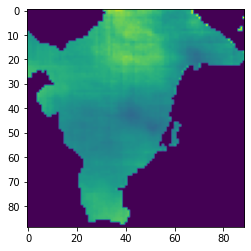

In [3]:
pickle_in = open("/content/drive/MyDrive/Preprosessing_data/rainfall_flatten.pickle","rb")
# data diload sudah dalam bentuk 1D
X = pickle.load(pickle_in)
# untuk menampilkan gambar data 1D -> 2D
plt.imshow(X[-96].reshape(89,89))

In [4]:
df = X

data_4 = df[:-12]

In [5]:
train, valid, test = df[:-96], df[-96:-48], df[-48:]
# len(train)

In [6]:
scaler = MinMaxScaler()
scaler.fit(train)
scaler.fit(data_4)
scaler.fit(valid)
scaler.fit(test)
train = scaler.transform(train)
data_4 = scaler.transform(data_4)
valid = scaler.transform(valid)
test = scaler.transform(test)

In [7]:
n_input = 12
n_features = 7921
batch_size = 12
# supervised data
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=batch_size)
validation_sequence = TimeseriesGenerator(valid,valid, length=n_input, batch_size=12)
test_sequence = TimeseriesGenerator(test,test, length=n_input, batch_size=12)

In [8]:
# from keras.layers import *
# from keras.models import *
# from keras import backend as K

# class attention(Layer):
    
#     def __init__(self, return_sequences=True):
#         self.return_sequences = return_sequences
#         super(attention,self).__init__()
#     # def get_config(self):
#     #   config = super().get_config().copy()
#     #   config.update({'return_sequences': self.return_sequences})
#     #   return config
        
#     def build(self, input_shape):
        
#         self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
#                                initializer="normal")
#         self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
#                                initializer="zeros")
        
#         super(attention,self).build(input_shape)
        
#     def call(self, x):
        
#         e = K.tanh(K.dot(x,self.W)+self.b)
#         a = K.softmax(e, axis=1)
#         output = x*a
        
#         if self.return_sequences:
#             return output
        
#         return K.sum(output, axis=1)

In [9]:
from keras.layers import Layer
from keras.layers import *
from keras.models import *
from keras import backend as K

class attention(Layer):
    def __init__(self, units=500, **kwargs):
        self.units = units
        super(attention,self).__init__(**kwargs)
 
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)
 
    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context
    
    def get_config(self):
        config = super(attention, self).get_config()
        config.update({"units": self.units})
        return config
    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [10]:
Simple_RNN = Sequential()
Simple_RNN.add(SimpleRNN(228, input_shape=(n_input, n_features)))
Simple_RNN.add(Dense(n_features, activation='ReLU', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=1)))
optimizer = keras.optimizers.Adam(learning_rate=0.001)
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
Simple_RNN.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

checkpointer_1 = ModelCheckpoint(filepath="/content/drive/MyDrive/Weight/Simple_RNN_weight.hdf5" , verbose=0, save_best_only=True)
earlystopper_1 = EarlyStopping(monitor='val_loss', patience=100, verbose=0)
with open("/content/drive/MyDrive/Weight/Simple_RNN.json", "w") as m:
  m.write(Simple_RNN.to_json())

In [11]:
Vanila_LSTM = Sequential()
Vanila_LSTM.add(LSTM(228, input_shape=(n_input, n_features), return_sequences=True))
Vanila_LSTM.add(Dense(n_features, activation='ReLU', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=1)))
optimizer = keras.optimizers.Adam(learning_rate=0.001)
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
Vanila_LSTM.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

checkpointer_2 = ModelCheckpoint(filepath="/content/drive/MyDrive/Weight/Vanila_LSTM_weight.hdf5" , verbose=0, save_best_only=True)
earlystopper_2 = EarlyStopping(monitor='val_loss', patience=100, verbose=0)
with open("/content/drive/MyDrive/Weight/Vanila_LSTM.json", "w") as m:
  m.write(Vanila_LSTM.to_json())

In [12]:
Stacked_LSTM2 = Sequential()
Stacked_LSTM2.add(LSTM(228, input_shape=(n_input, n_features), return_sequences=True))
Stacked_LSTM2.add(LSTM(300, return_sequences=False))
Stacked_LSTM2.add(Dense(n_features, activation='ReLU', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=1)))
optimizer = keras.optimizers.Adam(learning_rate=0.001)
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
Stacked_LSTM2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

checkpointer_3 = ModelCheckpoint(filepath="/content/drive/MyDrive/Weight/Stacked_LSTM2_weight.hdf5" , verbose=0, save_best_only=True)
earlystopper_3 = EarlyStopping(monitor='val_loss', patience=100, verbose=0)
with open("/content/drive/MyDrive/Weight/Stacked_LSTM2.json", "w") as m:
  m.write(Stacked_LSTM2.to_json())

In [13]:
Stacked_LSTM3 = Sequential()
Stacked_LSTM3.add(LSTM(228, input_shape=(n_input, n_features), return_sequences=True))
Stacked_LSTM3.add(LSTM(300, return_sequences=True))
Stacked_LSTM3.add(LSTM(500, return_sequences=False))
Stacked_LSTM3.add(Dense(n_features, activation='ReLU', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=1)))
optimizer = keras.optimizers.Adam(learning_rate=0.001)
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
Stacked_LSTM3.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

checkpointer_4 = ModelCheckpoint(filepath="/content/drive/MyDrive/Weight/Stacked_LSTM3_weight.hdf5" , verbose=0, save_best_only=True)
earlystopper_4 = EarlyStopping(monitor='val_loss', patience=100, verbose=0)
with open("/content/drive/MyDrive/Weight/Stacked_LSTM3.json", "w") as m:
  m.write(Stacked_LSTM3.to_json())

In [14]:
Stacked_LSTM3_AT = Sequential()
Stacked_LSTM3_AT.add(LSTM(228, input_shape=(n_input, n_features), return_sequences=True))
Stacked_LSTM3_AT.add(LSTM(300, return_sequences=True))
Stacked_LSTM3_AT.add(LSTM(500, return_sequences=True))
Stacked_LSTM3_AT.add(attention())
Stacked_LSTM3_AT.add(Dense(n_features, activation='ReLU', kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=1)))
optimizer = keras.optimizers.Adam(learning_rate=0.001)
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
Stacked_LSTM3_AT.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

print(tf.keras.layers.serialize(Stacked_LSTM3_AT))
# prints the configuration of the model, as a dict.

# Retrieve the config
config = Stacked_LSTM3_AT.get_config()

# At loading time, register the custom objects with a `custom_object_scope`:
custom_objects = {"attention": Layer}
# with keras.utils.custom_object_scope(custom_objects):
  # Stacked_LSTM3_AT = keras.Model.from_config(config)

checkpointer_5 = ModelCheckpoint(filepath="/content/drive/MyDrive/Weight/Stacked_LSTM3_AT_weight.hdf5" , verbose=0, save_best_only=True)
earlystopper_5 = EarlyStopping(monitor='val_loss', patience=100, verbose=0)
with open("/content/drive/MyDrive/Weight/Stacked_LSTM3_AT.json", "w") as m:
  m.write(Stacked_LSTM3_AT.to_json())

{'class_name': 'Sequential', 'config': {'name': 'sequential_4', 'layers': [{'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 12, 7921), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'lstm_6_input'}}, {'class_name': 'LSTM', 'config': {'name': 'lstm_6', 'trainable': True, 'batch_input_shape': (None, 12, 7921), 'dtype': 'float32', 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'time_major': False, 'units': 228, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'recurrent_initializer': {'class_name': 'Orthogonal', 'config': {'gain': 1.0, 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'unit_forget_bias': True, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_const

In [15]:
Stacked_LSTM3_AT.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 12, 228)           7432800   
                                                                 
 lstm_7 (LSTM)               (None, 12, 300)           634800    
                                                                 
 lstm_8 (LSTM)               (None, 12, 500)           1602000   
                                                                 
 attention (attention)       (None, 500)               512       
                                                                 
 dense_4 (Dense)             (None, 7921)              3968421   
                                                                 
Total params: 13,638,533
Trainable params: 13,638,533
Non-trainable params: 0
_________________________________________________________________


In [16]:
Simple_RNN_history = Simple_RNN.fit(generator, epochs=1000, validation_data=validation_sequence, callbacks=[checkpointer_1, earlystopper_1])

Epoch 1/1000
31/31 [==============================] - 4s 44ms/step - loss: 0.0923 - mae: 0.1777 - val_loss: 0.0580 - val_mae: 0.1333
Epoch 2/1000
31/31 [==============================] - 1s 23ms/step - loss: 0.0603 - mae: 0.1344 - val_loss: 0.0508 - val_mae: 0.1232
Epoch 3/1000
31/31 [==============================] - 1s 23ms/step - loss: 0.0527 - mae: 0.1241 - val_loss: 0.0452 - val_mae: 0.1143
Epoch 4/1000
31/31 [==============================] - 1s 24ms/step - loss: 0.0503 - mae: 0.1211 - val_loss: 0.0443 - val_mae: 0.1121
Epoch 5/1000
31/31 [==============================] - 1s 24ms/step - loss: 0.0469 - mae: 0.1165 - val_loss: 0.0409 - val_mae: 0.1081
Epoch 6/1000
31/31 [==============================] - 1s 23ms/step - loss: 0.0456 - mae: 0.1147 - val_loss: 0.0407 - val_mae: 0.1089
Epoch 7/1000
31/31 [==============================] - 1s 17ms/step - loss: 0.0458 - mae: 0.1160 - val_loss: 0.0407 - val_mae: 0.1104
Epoch 8/1000
31/31 [==============================] - 1s 17ms/step - 

In [17]:
Vanila_LSTM_history = Vanila_LSTM.fit(generator, epochs=1000, validation_data=validation_sequence, callbacks=[checkpointer_2, earlystopper_2])

Epoch 1/1000
31/31 [==============================] - 6s 63ms/step - loss: 0.0728 - mae: 0.1552 - val_loss: 0.0491 - val_mae: 0.1208
Epoch 2/1000
31/31 [==============================] - 1s 23ms/step - loss: 0.0524 - mae: 0.1251 - val_loss: 0.0465 - val_mae: 0.1175
Epoch 3/1000
31/31 [==============================] - 1s 24ms/step - loss: 0.0502 - mae: 0.1228 - val_loss: 0.0447 - val_mae: 0.1152
Epoch 4/1000
31/31 [==============================] - 2s 51ms/step - loss: 0.0487 - mae: 0.1212 - val_loss: 0.0430 - val_mae: 0.1129
Epoch 5/1000
31/31 [==============================] - 0s 11ms/step - loss: 0.0461 - mae: 0.1172 - val_loss: 0.0463 - val_mae: 0.1184
Epoch 6/1000
31/31 [==============================] - 1s 22ms/step - loss: 0.0465 - mae: 0.1182 - val_loss: 0.0411 - val_mae: 0.1102
Epoch 7/1000
31/31 [==============================] - 1s 25ms/step - loss: 0.0450 - mae: 0.1161 - val_loss: 0.0402 - val_mae: 0.1088
Epoch 8/1000
31/31 [==============================] - 0s 11ms/step - 

In [18]:
Stacked_LSTM2_history = Stacked_LSTM2.fit(generator, epochs=1000, validation_data=validation_sequence, callbacks=[checkpointer_3, earlystopper_3])

Epoch 1/1000
31/31 [==============================] - 6s 79ms/step - loss: 0.0719 - mae: 0.1523 - val_loss: 0.0551 - val_mae: 0.1291
Epoch 2/1000
31/31 [==============================] - 1s 27ms/step - loss: 0.0570 - mae: 0.1288 - val_loss: 0.0524 - val_mae: 0.1263
Epoch 3/1000
31/31 [==============================] - 1s 27ms/step - loss: 0.0545 - mae: 0.1253 - val_loss: 0.0499 - val_mae: 0.1223
Epoch 4/1000
31/31 [==============================] - 1s 26ms/step - loss: 0.0533 - mae: 0.1237 - val_loss: 0.0451 - val_mae: 0.1127
Epoch 5/1000
31/31 [==============================] - 1s 26ms/step - loss: 0.0512 - mae: 0.1209 - val_loss: 0.0451 - val_mae: 0.1129
Epoch 6/1000
31/31 [==============================] - 0s 12ms/step - loss: 0.0521 - mae: 0.1222 - val_loss: 0.0457 - val_mae: 0.1140
Epoch 7/1000
31/31 [==============================] - 0s 12ms/step - loss: 0.0513 - mae: 0.1216 - val_loss: 0.0461 - val_mae: 0.1141
Epoch 8/1000
31/31 [==============================] - 1s 26ms/step - 

In [19]:
Stacked_LSTM3_history = Stacked_LSTM3.fit(generator, epochs=1000, validation_data=validation_sequence, callbacks=[checkpointer_4, earlystopper_4])

Epoch 1/1000
31/31 [==============================] - 8s 111ms/step - loss: 0.0739 - mae: 0.1544 - val_loss: 0.0548 - val_mae: 0.1266
Epoch 2/1000
31/31 [==============================] - 1s 39ms/step - loss: 0.0618 - mae: 0.1355 - val_loss: 0.0546 - val_mae: 0.1267
Epoch 3/1000
31/31 [==============================] - 0s 15ms/step - loss: 0.0600 - mae: 0.1332 - val_loss: 0.0549 - val_mae: 0.1287
Epoch 4/1000
31/31 [==============================] - 2s 52ms/step - loss: 0.0573 - mae: 0.1292 - val_loss: 0.0488 - val_mae: 0.1190
Epoch 5/1000
31/31 [==============================] - 1s 34ms/step - loss: 0.0557 - mae: 0.1276 - val_loss: 0.0478 - val_mae: 0.1172
Epoch 6/1000
31/31 [==============================] - 0s 15ms/step - loss: 0.0528 - mae: 0.1224 - val_loss: 0.0486 - val_mae: 0.1195
Epoch 7/1000
31/31 [==============================] - 1s 33ms/step - loss: 0.0528 - mae: 0.1227 - val_loss: 0.0460 - val_mae: 0.1134
Epoch 8/1000
31/31 [==============================] - 0s 15ms/step -

In [20]:
Stacked_LSTM3_AT_history = Stacked_LSTM3_AT.fit(generator, epochs=1000, validation_data=validation_sequence, callbacks=[checkpointer_5, earlystopper_5])

Epoch 1/1000
31/31 [==============================] - 9s 120ms/step - loss: 0.0765 - mae: 0.1567 - val_loss: 0.0588 - val_mae: 0.1329
Epoch 2/1000
31/31 [==============================] - 1s 36ms/step - loss: 0.0658 - mae: 0.1407 - val_loss: 0.0560 - val_mae: 0.1282
Epoch 3/1000
31/31 [==============================] - 0s 15ms/step - loss: 0.0649 - mae: 0.1399 - val_loss: 0.0560 - val_mae: 0.1282
Epoch 4/1000
31/31 [==============================] - 0s 15ms/step - loss: 0.0637 - mae: 0.1378 - val_loss: 0.0561 - val_mae: 0.1285
Epoch 5/1000
31/31 [==============================] - 1s 33ms/step - loss: 0.0642 - mae: 0.1382 - val_loss: 0.0556 - val_mae: 0.1275
Epoch 6/1000
31/31 [==============================] - 1s 34ms/step - loss: 0.0634 - mae: 0.1373 - val_loss: 0.0553 - val_mae: 0.1272
Epoch 7/1000
31/31 [==============================] - 1s 35ms/step - loss: 0.0626 - mae: 0.1368 - val_loss: 0.0552 - val_mae: 0.1277
Epoch 8/1000
31/31 [==============================] - 0s 16ms/step -

In [21]:
def plot_loss(history, title):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(title)
    plt.xlabel('Nb Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    loss = history.history['loss']
    min_idx = np.argmin(loss)
    min_loss = loss[min_idx]
    print('Minimum loss of {} reached at epoch {}'.format(min_loss, min_idx))
    
    val_loss = history.history['val_loss']
    min_idx = np.argmin(val_loss)
    min_val_loss = val_loss[min_idx]
    print('Minimum validation loss of {} reached at epoch {}'.format(min_val_loss, min_idx))

In [22]:
def plot_metrics(history, title):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['mae'], label='Train', color= 'g')
    plt.plot(history.history['val_mae'], label='Validation', color= 'r')
    plt.title(title)
    plt.xlabel('Nb Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()
    
    mae = history.history['mae']
    min_idx = np.argmin(mae)
    min_mae = mae[min_idx]
    print('Minimum loss of {} reached at epoch {}'.format(min_mae, min_idx))

    val_mae = history.history['val_mae']
    min_idx = np.argmin(val_mae)
    min_val_mae = val_mae[min_idx]
    print('Minimum validation mae of {} reached at epoch {}'.format(min_val_mae, min_idx))

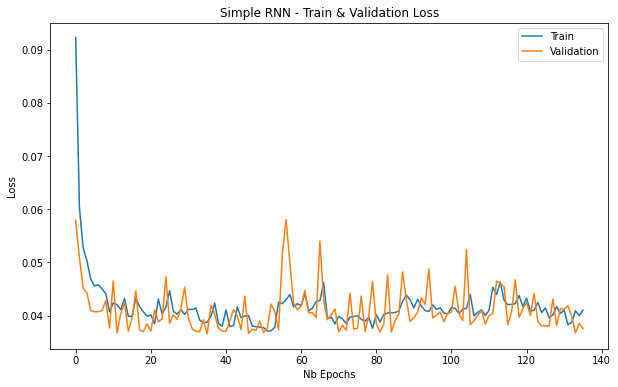

Minimum loss of 0.03708638250827789 reached at epoch 51
Minimum validation loss of 0.03654691204428673 reached at epoch 35


In [23]:
plot_loss(Simple_RNN_history, 'Simple RNN - Train & Validation Loss')

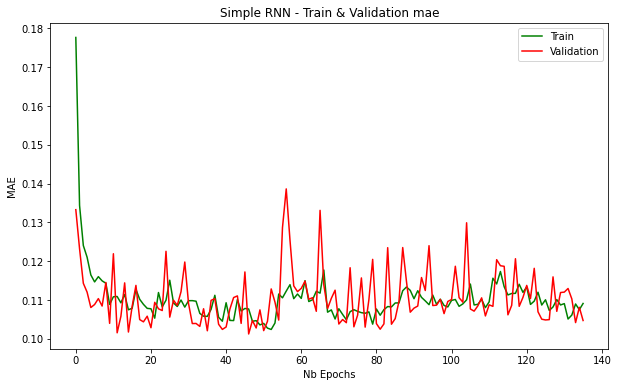

Minimum loss of 0.1024399846792221 reached at epoch 52
Minimum validation mae of 0.10127716511487961 reached at epoch 46


In [24]:
plot_metrics(Simple_RNN_history, 'Simple RNN - Train & Validation mae')

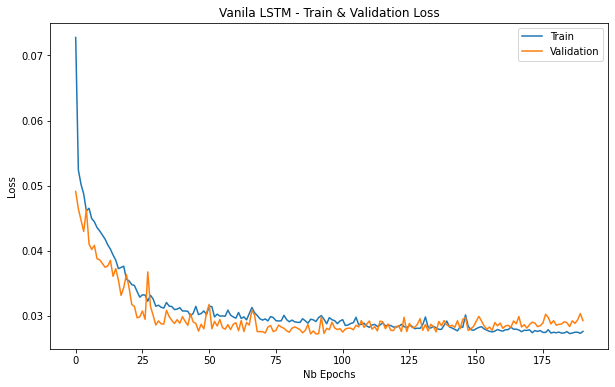

Minimum loss of 0.027284611016511917 reached at epoch 185
Minimum validation loss of 0.027224721387028694 reached at epoch 90


In [25]:
plot_loss(Vanila_LSTM_history, 'Vanila LSTM - Train & Validation Loss')

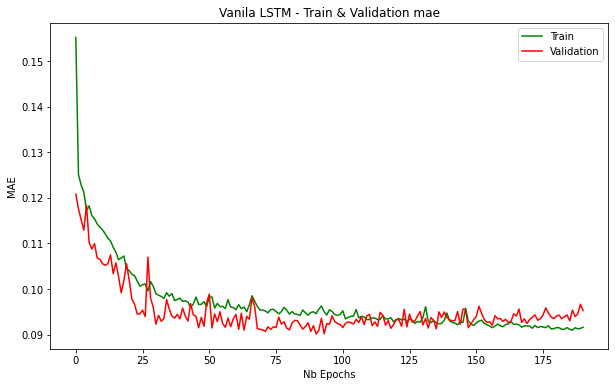

Minimum loss of 0.09097012132406235 reached at epoch 186
Minimum validation mae of 0.09013789892196655 reached at epoch 90


In [26]:
plot_metrics(Vanila_LSTM_history, 'Vanila LSTM - Train & Validation mae')

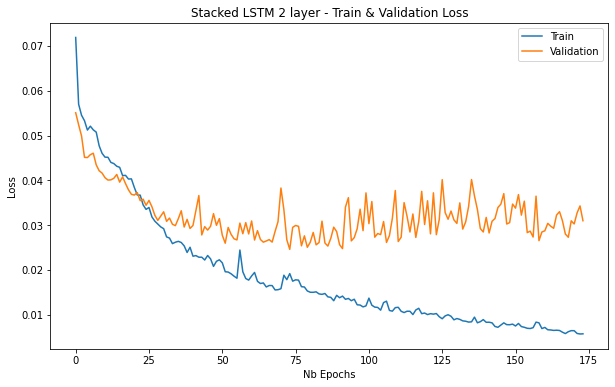

Minimum loss of 0.00570504879578948 reached at epoch 172
Minimum validation loss of 0.02459634095430374 reached at epoch 73


In [27]:
plot_loss(Stacked_LSTM2_history, 'Stacked LSTM 2 layer - Train & Validation Loss')

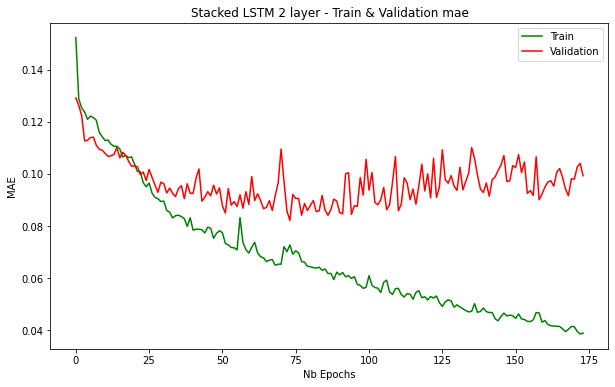

Minimum loss of 0.03860460966825485 reached at epoch 172
Minimum validation mae of 0.08213003724813461 reached at epoch 73


In [28]:
plot_metrics(Stacked_LSTM2_history, 'Stacked LSTM 2 layer - Train & Validation mae')

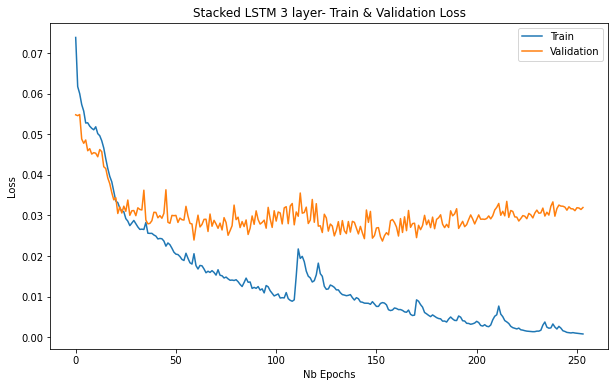

Minimum loss of 0.0007827738882042468 reached at epoch 253
Minimum validation loss of 0.023681877180933952 reached at epoch 153


In [29]:
plot_loss(Stacked_LSTM3_history, 'Stacked LSTM 3 layer- Train & Validation Loss')

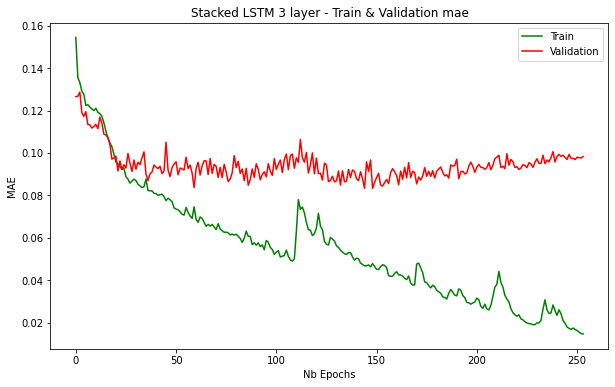

Minimum loss of 0.014614074490964413 reached at epoch 253
Minimum validation mae of 0.08322472125291824 reached at epoch 148


In [30]:
plot_metrics(Stacked_LSTM3_history, 'Stacked LSTM 3 layer - Train & Validation mae')

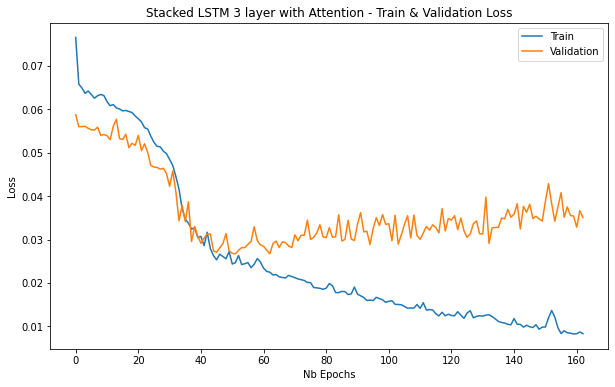

Minimum loss of 0.00823565199971199 reached at epoch 159
Minimum validation loss of 0.026697715744376183 reached at epoch 62


In [31]:
plot_loss(Stacked_LSTM3_AT_history, 'Stacked LSTM 3 layer with Attention - Train & Validation Loss')

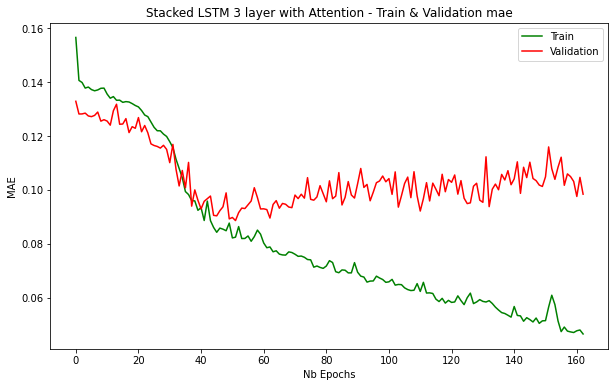

Minimum loss of 0.04646652564406395 reached at epoch 162
Minimum validation mae of 0.08860877901315689 reached at epoch 51


In [32]:
plot_metrics(Stacked_LSTM3_AT_history, 'Stacked LSTM 3 layer with Attention - Train & Validation mae')

In [34]:
def eval_best_model(model_):
    # Load model architecture from JSON
    model_architecture = open('/content/drive/MyDrive/Weight/'+model_+'.json', 'r')
    best_model = model_from_json(model_architecture.read())
    model_architecture.close()
    # Load best model's weights
    best_model.load_weights('/content/drive/MyDrive/Weight/'+model_+'_weight.hdf5')
    # Compile the best model
    best_model.compile(loss='mean_squared_error', optimizer='adam')
    # Evaluate on test data
    perf_best_model = best_model.evaluate_generator(test_sequence)
    print('Loss on test data for {} : {}'.format(model_, perf_best_model))

def eval_best_model_AT(model_):
    # Load model architecture from JSON
    model_architecture = open('/content/drive/MyDrive/Weight/'+model_+'.json', 'r')
    best_model = model_from_json(model_architecture.read(), custom_objects = {"attention": attention})
    model_architecture.close()
    # Load best model's weights
    best_model.load_weights('/content/drive/MyDrive/Weight/'+model_+'_weight.hdf5')
    # Compile the best model
    best_model.compile(loss='mean_squared_error', optimizer='adam')
    # Evaluate on test data
    perf_best_model = best_model.evaluate_generator(test_sequence)
    print('Loss on test data for {} : {}'.format(model_, perf_best_model))

eval_best_model('Simple_RNN')
eval_best_model('Vanila_LSTM')
eval_best_model('Stacked_LSTM2')
eval_best_model('Stacked_LSTM3')
eval_best_model_AT('Stacked_LSTM3_AT')

Loss on test data for Simple_RNN : 0.029079966247081757
Loss on test data for Vanila_LSTM : 0.02355254627764225
Loss on test data for Stacked_LSTM2 : 0.019498083740472794
Loss on test data for Stacked_LSTM3 : 0.021140586584806442
Loss on test data for Stacked_LSTM3_AT : 0.027422549203038216
